# Create a DCGAN model for generating fake handwritten Chinese "hanzi" characters
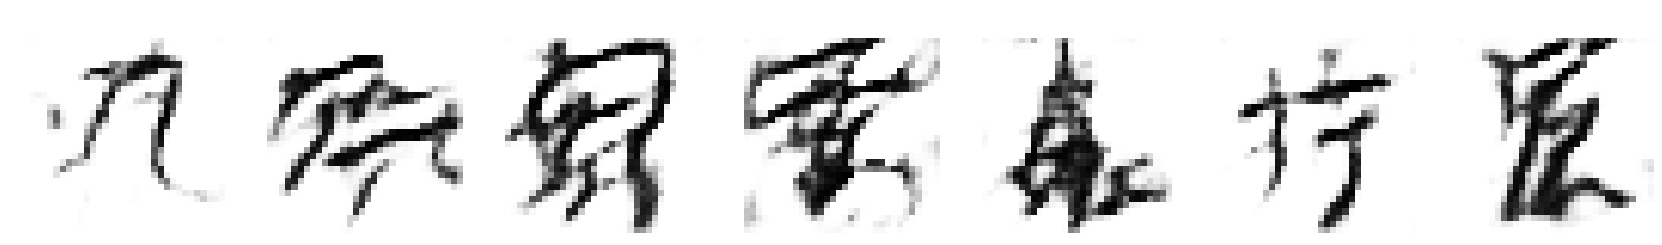
Begin by installing the input database. Learn more about the database [here](https://www.kaggle.com/datasets/vitaliikyzym/chinese-handwriting-recognition-hsk-1). The dataset is a collection of 178 handwritten characters featured in the HSK 1 test. The images are a subset of the [CASIA Online and Offline Chinese Handwriting Databases](http://www.nlpr.ia.ac.cn/databases/handwriting/Home.html)



In [ ]:
!pip install kaggle # install for Kaggle database access
# make sure to upload your kaggle.json API key to the root folder in Colab before running
!kaggle datasets download -d vitaliikyzym/chinese-handwriting-recognition-hsk-1 

In [ ]:
# Unzip the dataset zip file
import zipfile
zipPath = "/content/chinese-handwriting-recognition-hsk-1.zip"
with zipfile.ZipFile(zipPath) as z:
  for file in z.namelist():
    z.extract(file,"/content/archive")

In [ ]:
# Imports
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time 
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import random
import sys
import cv2
from keras.models import load_model

# Preprocessing input image data
The kaggle dataset includes both a "train" folder and "test" folder meant for text recognition purposes. 

Modify this code to include more images if you'd like.

To prepare the images for training, each png is shrunk by more than 50% to a 32x32 size. More input pixels slow down training exponentially. The contrast of the images are also boosted.

In [ ]:
train_path = "/content/archive/chinese-handwriting/CASIA-HWDB_Train/Train"
test_path = "/content/archive/chinese-handwriting/CASIA-HWDB_Test/Test" 
train_chinese = os.listdir(train_path)
test_chinese = os.listdir(test_path)

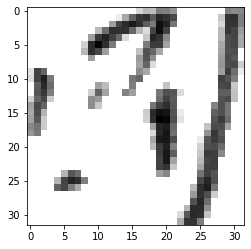

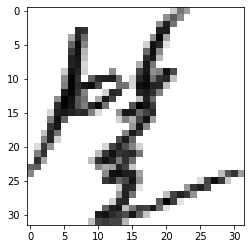

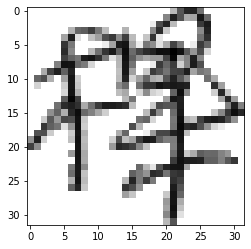

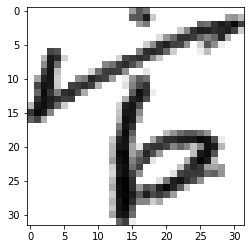

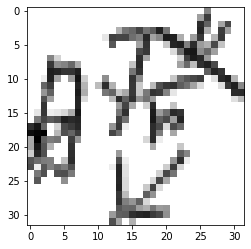

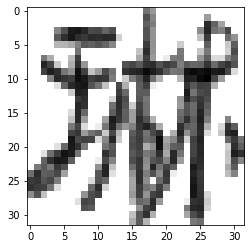

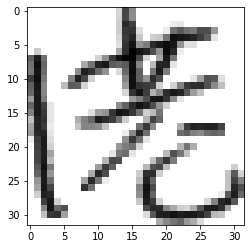

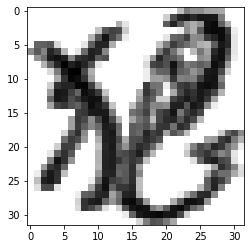

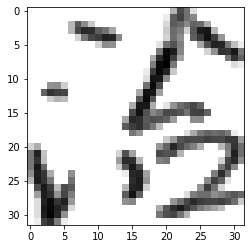

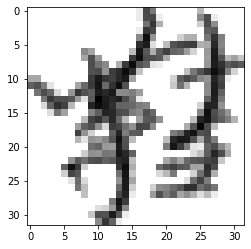

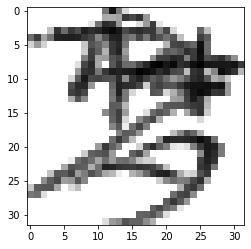

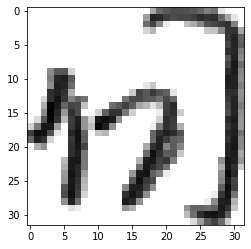

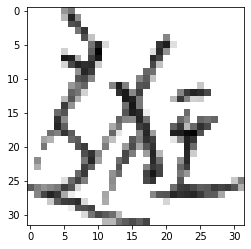

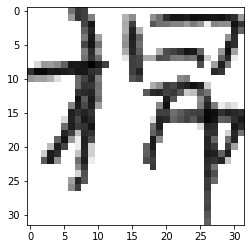

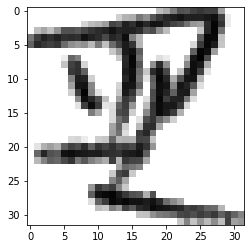

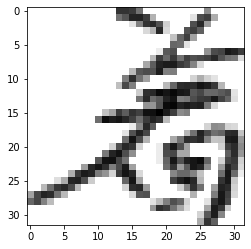

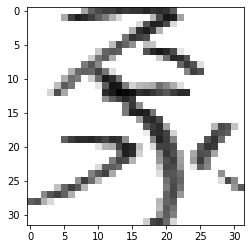

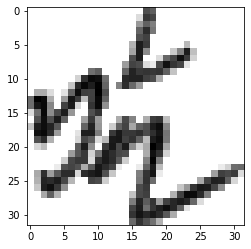

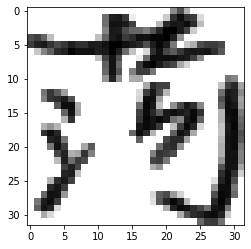

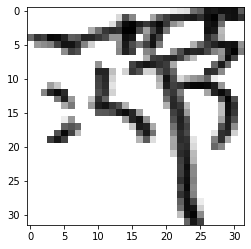

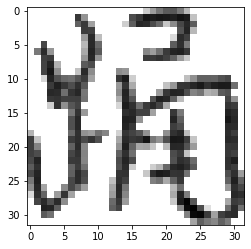

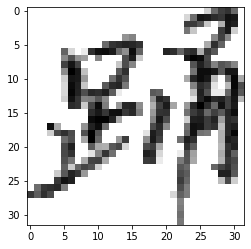

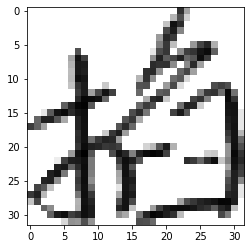

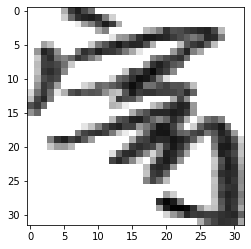

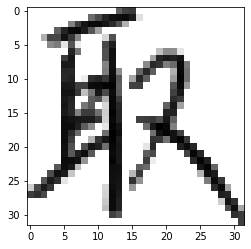

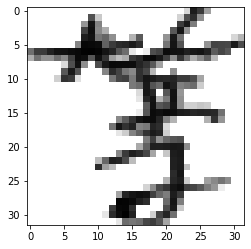

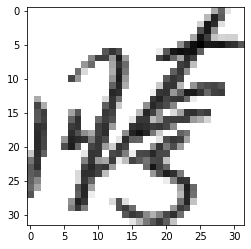

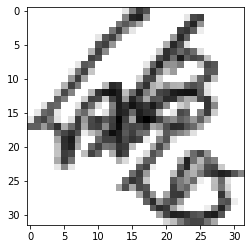

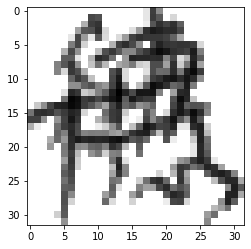

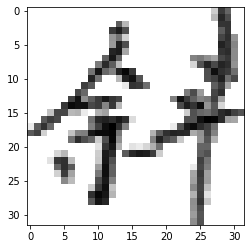

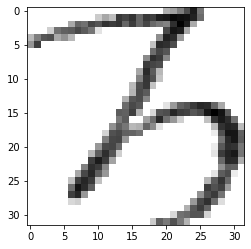

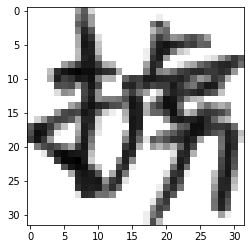

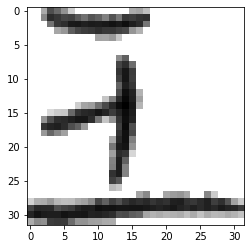

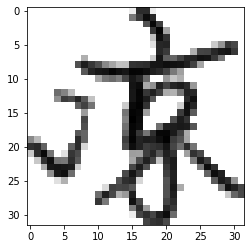

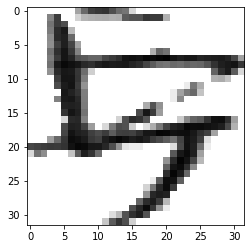

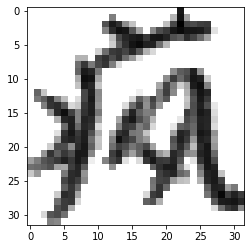

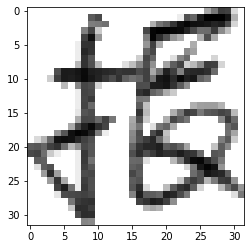

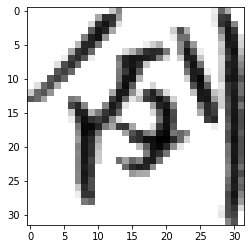

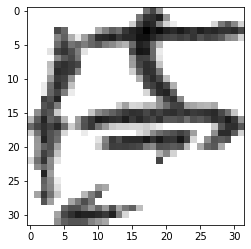

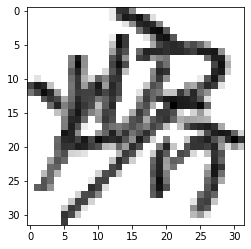

In [ ]:
df_train = []
a = 0.5
max_images = 40
image_count = 0
for e in train_chinese:
  try:
    for ee in os.listdir(test_path+"/"+e):
      img_path = test_path+"/"+e+"/"+ee
      img = cv2.imread(img_path,0)
      img = cv2.resize(img, (32,32), cv2.INTER_AREA) # Area interpolation (vs linear, bicubic, etc.) is generally the best sampling method for shrinking images.

      # Boost contrast. Pixel "blackness" has the following function applied: f(x) = sqrt(x/255)
      img = 255*(1 - np.power(np.divide(255-img,255), a))

      if random.random() < 0.001: # Display 0.1% of all processed images
          if image_count < max_images:
              plt.imshow(img, cmap='gray')
              plt.show()
              image_count += 1
      df_train.append(img)
  except:
    pass

In [ ]:
df_train = np.asarray([e for e in df_train])

print(df_train[0].shape) # Image resolution
print(len(df_train)) # Number of total images in the training set

df_train = df_train.reshape(df_train.shape[0],32,32,1).astype('float32')
df_train = (df_train-127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256*3 # A high batch size helps even out training. In testing, this helped reduce learning brittleness at a slight cost to speed.

train_dataset = tf.data.Dataset.from_tensor_slices(df_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Specify where to save model checkpoints, images, and logs. I recommend mounting your Google Drive so that files could be saved outside of the Colab session. 


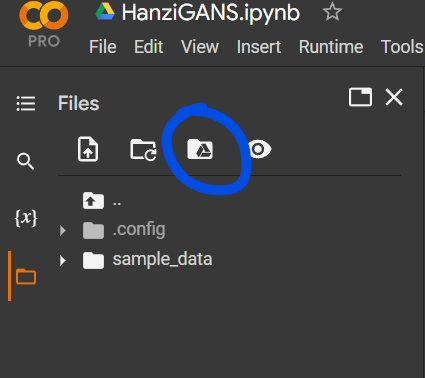

In [ ]:
results_dir = '/content/drive/MyDrive/Colab Notebooks/HanziGANS/'

# Create the Generator
A sequence of layers beginning with a Dense layer, two 2D Convolutional layers, and a final Convolutional layer with tanh activation to output an image with pixel values from -1 to 1. These values will be shifted to a 0-255 pixel brightness scale later for visualization.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

# Create the Discriminator
The Discriminator model funnels down to one output that corresponds to a 0-1 "real or not real" score for the input images. 

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(256, (10, 10), strides=(1, 1), padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define the Loss functions
These provide the networks a metric to optimize and learn by.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Prepare training loop
When I adapted the code for the Tensorboard DCGAN tutorial, I found that the tutorial checkpointing code did not work. I wrote new functions to get propert checkpointing behavior.

In [ ]:
# Initialize the models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator = make_generator_model()
discriminator = make_discriminator_model()

EPOCHS = 300
save_every = 15 # saves the model and its weights every "save_every" epochs
noise_dim = 100
rows_to_generate = 4 # to display at the end of every epoch
columns_to_generate = 4
seed = tf.random.normal([rows_to_generate*columns_to_generate, noise_dim])

In [ ]:
# Improved checkpointing
def loadChkpt(epoch = None):
    if epoch is not None:
        generator = load_model(results_dir+'checkpoints/generator_at_epoch_{:04d}.h5'.format(epoch))
        discriminator = load_model(results_dir+'checkpoints/discriminator_at_epoch_{:04d}.h5'.format(epoch))
    else:
        filenames = glob.glob(results_dir+'checkpoints/generator_at_epoch*.h5')
        filenames = sorted(filenames, reverse=True)
        generator = load_model(filenames[0])
        filenames = glob.glob(results_dir+'checkpoints/discriminator_at_epoch*.h5')
        filenames = sorted(filenames, reverse=True)
        discriminator = load_model(filenames[0])
    return generator, discriminator

def saveChkpt(epoch):
    generator.save(
        results_dir+'checkpoints/generator_at_epoch_{:04d}.h5'.format(epoch),
        overwrite=True,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
        save_traces=True,
    )
    discriminator.save(
        results_dir+'checkpoints/discriminator_at_epoch_{:04d}.h5'.format(epoch),
        overwrite=True,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
        save_traces=True,
    )

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

import datetime

def train(dataset, epochs, log=True):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Tensorboard logging. Learn more about tensorboard here: https://www.tensorflow.org/tensorboard/
    if log:
      train_log_dir = results_dir+'logs/gradient_tape/' + current_time + '/train'
      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=train_log_dir, histogram_freq=1, write_graph=True)
      train_summary_writer = tf.summary.create_file_writer(train_log_dir)


    for epoch in range(epochs):
        start = time.time()
        print(start)

        batch = 0
        for image_batch in dataset:
            print(batch)
            batch += 1
            gen_loss, disc_loss = train_step(image_batch)
        
        if log:
          with train_summary_writer.as_default():
              tf.summary.scalar('generator loss', gen_loss, step=epoch)
              tf.summary.scalar('discriminator loss', disc_loss, step=epoch)

        # Produce images for the GIF as you go
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save model every 15 epochs
        if (epoch + 1) % save_every == 0:
            saveChkpt(epoch)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    #generate after final epoch
    generate_and_save_images(generator,epochs,seed)

def generate_and_save_images(model, epoch, test_input):
    # run in inference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(columns_to_generate,rows_to_generate))

    for i in range(predictions.shape[0]):
        plt.subplot(rows_to_generate,columns_to_generate,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(results_dir+'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# Begin Training


In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:
generator, discriminator = loadChkpt() # Optionally load the latest checkpoint.

In [ ]:
train(train_dataset,EPOCHS,log=True)

# Create and save GIF


In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
anim_file = results_dir+'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(results_dir+'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)